<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Current-conclusions" data-toc-modified-id="Current-conclusions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Current conclusions</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Test-runs" data-toc-modified-id="Test-runs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Test runs</a></span></li><li><span><a href="#Interact" data-toc-modified-id="Interact-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Interact</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Investigating-the-stability-of-several-models" data-toc-modified-id="Investigating-the-stability-of-several-models-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Investigating the stability of several models</a></span></li><li><span><a href="#Is-it-possible-to-have-both-constraints-on-the-transition-threshold-valid?" data-toc-modified-id="Is-it-possible-to-have-both-constraints-on-the-transition-threshold-valid?-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Is it possible to have both constraints on the transition threshold valid?</a></span></li><li><span><a href="#Stability-of-the-delta<-1-model" data-toc-modified-id="Stability-of-the-delta<-1-model-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Stability of the delta&lt; 1 model</a></span><ul class="toc-item"><li><span><a href="#delta-=-0" data-toc-modified-id="delta-=-0-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>delta = 0</a></span></li><li><span><a href="#simple-system" data-toc-modified-id="simple-system-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>simple system</a></span></li></ul></li></ul></div>

# Description

This notebook investigates the stability of different cell cycle models. 

# Current conclusions

- Size threshold for G1/S: always stable
- Concentration threshold for G1/s: 
    - unstable for delta = 1 in general
    - stable for delta < 1

# Load

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from RBmodel import cell_models

from ipywidgets import interact, fixed, interact_manual
from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks

In [4]:
from RBmodel.analysis import get_cycle_stats

In [6]:
from RBmodel.plot_utils import run_and_plot_test

In [7]:
from RBmodel import load_utils

# Model

$$
\frac{\partial RB}{\partial t} = M^\delta - \beta RB, \\
\frac{\partial M}{\partial t} = \gamma M^\delta, \\
\beta = \beta \text{ in G1 and } \beta = \varepsilon \beta \text{ in G2.} 
$$

# Test runs

Build something with interact so that you can get a rough sense of how the system behaves. 

In [10]:
# cell_test, periods= run_and_plot_test()

# Interact

In [11]:
interact_manual(
    run_and_plot_test, 
    alpha=fixed(.1),# synthesis rate - (.1, 10., step), 
    beta0=(.01, .4, .01), # degradation rate in G1
    epsilon=(.1, 2., .1), # ratio of deg. rates in G2/G1 (.1, 1., step), 
    gamma=(.01, .05, .01),  # growth rate
    time_SG2 = fixed(12),#(1, 15), # time spent in SG2
    delta=(0, 1, .1), # exponent for growth
    dt=fixed(1e-1), #time step
    division=fixed("timer"), # timer or sizer
    transition=fixed("size"), # "size" or "RBc"
    transition_th=fixed(1.3), # linked to the type of transition
    k_trans=fixed(1000), # 
    T=fixed(1000)
);

interactive(children=(FloatSlider(value=0.4, description='beta0', max=0.4, min=0.01, step=0.01), FloatSlider(v…

Result for size-based transition seem to be insensitive to threshold mass, and alpha. is that true? 

# Functions

The below functions have been derived mathematically and provide a theoretical evolution of the different parameters

# Investigating the stability of several models

In [12]:
params=cell_models.DEFAULT_PARAMS.copy()
params['k_trans'] = 1000
params['transition'] = 'RBc' # 'size'
params['gamma'] = .01
params['beta0'] = .5
params['alpha'] = .01
params['epsilon'] = .02
params['duration_SG2'] = 66
params['delta'] = 1.


In [13]:
limit_th = cell_models.check_conditions(params)

In [14]:
limit_th # technically the value of transition_th that gives you M_k+1 = M_k

0.13283808200600666

In [15]:
params['transition_th'] = limit_th 

In [16]:
cell = cell_models.cell(params=params)

cell.grow(int(5e4))

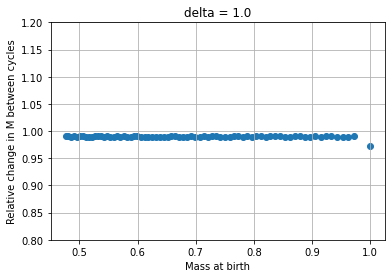

In [17]:
_, stats = load_utils.get_phase_durations(cell)

rats = [stats['birth'][i+1]/stats['birth'][i] for i in range(len(stats['birth'])-1)]

plt.scatter(stats['birth'][:-1], rats)
plt.ylim([.8, 1.2])

plt.ylabel("Relative change in M between cycles")
plt.xlabel("Mass at birth")
plt.title(f"delta = {params['delta']}")
plt.grid()

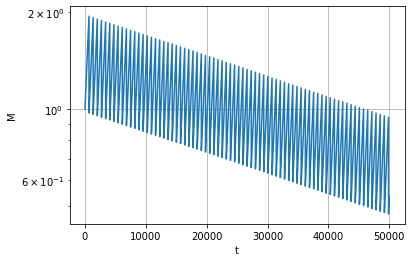

In [18]:
_, ax = plt.subplots()

# ic = {"RB": init_cond[0], "M": init_cond[1]}


ax.plot(cell.M_hist)
    
ax.grid()
ax.set_xlabel("t")
ax.set_ylabel("M")
# ax.set_title(f"k_trans = {params['k_trans']}")

ax.set_yscale('log')

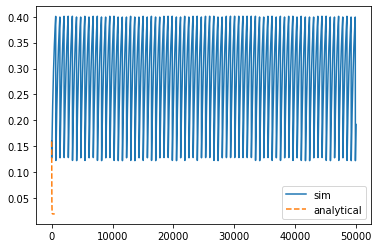

In [19]:
plt.plot(cell.RB_c_hist, label="sim")

t = np.linspace(0, 500*params['dt'], 500)
plt.plot(analytical_RBc(cell.RB_c_hist[0], params, t), linestyle='--', label='analytical')
plt.legend()

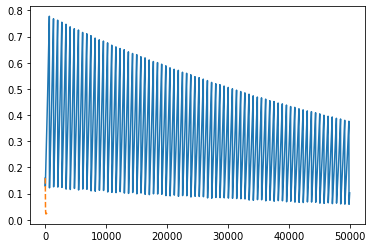

In [20]:
plt.plot(cell.RB_hist)
plt.plot(analytical_RB(cell.RB_hist[0], cell.M_hist[0], params, t), linestyle='--')

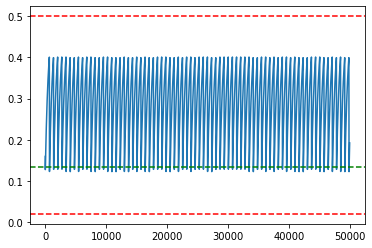

In [21]:
_, ax = plt.subplots()
ax.plot(cell.RB_c_hist)
ax.axhline([params['alpha']/(params['beta0'] + params['gamma'])], linestyle='--', color='red')
ax.axhline([params['alpha']/(params['beta0']*params['epsilon'] + params['gamma'])], linestyle='--', color='red')
ax.axhline([params['transition_th']], linestyle='--', color='green')

In [22]:
rats_sim = []
rats_th = []
th_vec = np.linspace(0.2, 1.5, 10)


for th in th_vec: 
    params_crt = params.copy()
    params_crt['transition_th'] = th * limit_th
    
    
    rats_th.append(theoretical_M_ratio(params_crt))
    cell_ = cell_models.cell(params=params_crt)
    cell_.grow(int(5e4))
    
    _, stats = load_utils.get_phase_durations(cell_)
    rats = [stats['birth'][i+1]/stats['birth'][i] for i in range(len(stats['birth'])-1)]
    
    rats_sim.append(np.mean(rats[-10:]))
    

Text(0.5, 1.0, 'Relative growth between two cycles')

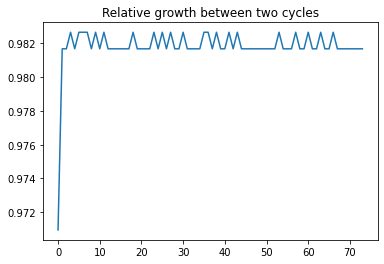

In [23]:
plt.plot(rats)
plt.title("Relative growth between two cycles")

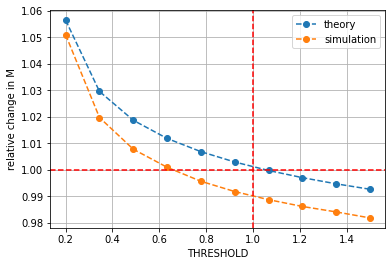

In [24]:
_, ax = plt.subplots()
ax.plot(th_vec, rats_th, 'o--', label="theory")
ax.plot(th_vec, rats_sim, 'o--', label="simulation")
ax.axvline([1], linestyle='--', color='red')
ax.axhline([1], linestyle='--', color='red')
ax.set_xlabel("THRESHOLD")
ax.set_ylabel("relative change in M")
ax.grid()
ax.legend()
# if that is correct, the value should act as a limit value for convergence vs divergence...

# Is it possible to have both constraints on the transition threshold valid? 

In [25]:
params=cell_models.DEFAULT_PARAMS.copy()
params['k_trans'] = 1000
params['transition'] = 'RBc' # 'size'
params['gamma'] = .01
params['beta0'] = .5
params['alpha'] = .01
params['epsilon'] = .02
params['duration_SG2'] = 10

(0.01764705882352941, 0.75)

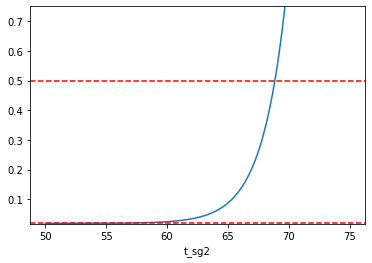

In [26]:
taus = np.linspace(50, 75, 100)

limit_values = []
for t in taus: 
    params_crt = params.copy()
    params_crt['duration_SG2'] = t
    
    limit_th = cell_models.check_conditions(params_crt)
    limit_values.append(limit_th)
    
    
C1 = params['alpha']/(params['beta0']+params['gamma'])
C2 = params['alpha']/(params['epsilon']*params['beta0']+params['gamma'])

_, ax = plt.subplots()
ax.plot(taus, limit_values)
ax.axhline([C1], color='red', linestyle='--')
ax.axhline([C2], color='red', linestyle='--')

ax.set_xlabel("t_sg2")
ax.set_ylim([.9*C1, 1.5*C2])

We can take a duration of 60 hours

# Stability of the delta< 1 model

We observe that the models with delta<1 are stable oscillators. Why? 

## delta = 0

In this case with the implicit function theorem we can map the derivative of the ratio of masses at G1 as a function of the mass at G1. This derivative looks to be always negative... is that even true? 

In [27]:
def dgdy(z, y, alpha, beta, gamma, epsilon, Omega, tau2): 
    A = -gamma * tau2 / y**2
    B = -gamma/beta * (Omega * z / (Omega * z * y - alpha/beta) - (Omega * np.exp(-epsilon*beta*tau2)))/((Omega * y - alpha/epsilon/beta) * np.exp(-epsilon*beta*tau2) + alpha/epsilon/beta - alpha/beta)
    return A + B

In [28]:
def dgdz(z, y, alpha, beta, gamma, epsilon, Omega, tau2):
    return -1-gamma/(beta*z-alpha/Omega/y)

In [29]:
alpha = 1
beta = .2
gamma = .4
epsilon = .2
Omega = .1
tau2 = 12

In [30]:
n_points = 1000

In [31]:
z_vec = np.linspace(1e-5, 1, n_points)

y_vec = np.linspace(1e-5, 1000, n_points)

In [32]:
dgdy_mat = np.zeros((n_points, n_points))

dgdz_mat = np.zeros((n_points, n_points))

In [33]:
for (k, z) in enumerate(z_vec):
    dgdy_mat[k, :] = dgdy(z, y_vec, alpha, beta, gamma, epsilon, Omega, tau2)
    dgdz_mat[k, :] = dgdz(z, y_vec, alpha, beta, gamma, epsilon, Omega, tau2)

In [34]:
dzdy = dgdz_mat**(-1) * dgdy_mat

In [35]:
dzdy_sign = dzdy>0

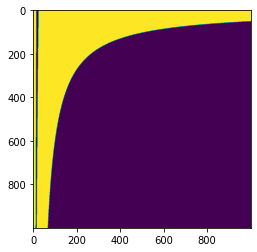

In [36]:
plt.imshow(dzdy_sign)

There is a surface with instability. So probably if you initialize your system there, you can reach this surface, right? You probably want to plot the flow, right? 

Actually, how can we think of the stability of a system that acts by multiplication? 

## simple system

In [37]:
y = lambda a, b, x: a*x+b

In [38]:
y2 = lambda a, b, x: np.exp(-a*x)+b

In [39]:
n_steps = 10000

a = 3
b = .4

sk = .1

sk_list = []
yk_list=[]

# run iterations
for k in range(n_steps): 
    yk = y2(a, b, sk)
    sk = yk*sk
    
    sk_list.append(sk)
    yk_list.append(yk)

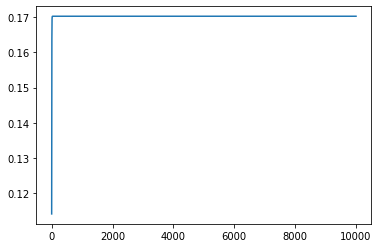

In [40]:
plt.plot(sk_list)

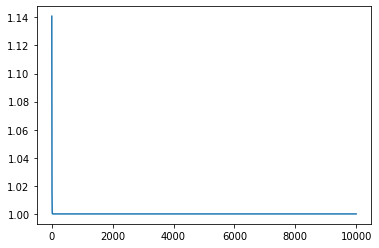

In [41]:
plt.plot(yk_list)

In [42]:
plt.plot(xx, y2(a, b, xx))
plt.scatter(sk_list, yk_list)

NameError: name 'xx' is not defined

In [ ]:
kk